In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import types

import data_jat as data


This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
d = data.Data('joyce-apj-background')
d.read_data(force_cache=True)


Found cached data from file eventdata_joyce-apj-background_20210420.pickle3.bz2, using contents...


In [3]:
l = list()
r = list()
u = list()

def weighted_avg(data, axis=0, weights=None, unc=False):
    """From Jon.  (Thanks Jon.)"""
    if weights is None:
        weights = np.empty(shape=data.shape, dtype=np.float64)
        weights.fill(1.)
    else:
        weights = weights.copy()
    data = data.copy()
    
    # Make NaN "disappear" from weights and input
    nanidx = np.isnan(data)
    weights[nanidx] = 0
    data[nanidx] = 0
    
    if unc:
        data = data ** 2
    sum_ = np.sum(data * weights, axis=axis)
    counts = np.sum(weights, axis=axis)
    
    if unc:
        sum_ = np.sqrt(sum_)
        
    # If there are no counts after averaging, then nan the output
    if len(sum_.shape) > 0:
        nocountidx = (counts == 0)
        counts[nocountidx] = 1
        sum_[nocountidx] = np.nan
    mean = sum_ / counts
    
    return mean


for i, event in enumerate(d.eventdata):
    e = types.SimpleNamespace(**copy.deepcopy(event['ChanP']))
    
    lookdir_idx = np.zeros((80), dtype=bool)
    lookdir_idx[20:50] = True
    lookdir_idx[np.array((25, 31, 34, 35, 44))] = False    
    
    fluxbad = np.isnan(e.flux)
    fluxbad = np.min(fluxbad[:, lookdir_idx, :], axis=1)
    fluxbad = np.min(fluxbad, axis=1)
    fluxgood = ~fluxbad

    l.append(np.sum(e.epoch_delta[fluxgood]) * 2)

    """
    From Colin:
    
    > -For each energy bin and look direction, do the sum of (flux * delta t)
    > over the entire quiet period, then divide by the total time of the quiet
    > period (including the half delta-t at each end?) Is there any fill in
    > the flux for this? Dividing by the total time if some time bins are fill
    > would tend to decrease the flux (treating fill as zero).

    Correct. I believe at that time, I did treat fills as zeros rather than removing the
    points, which would have been better.
    """
    # weighted average in time
    weights = e.epoch_delta
    # make weights the right dimensionality
    weights = np.tile(weights[:, None, None], (1,) + e.flux.shape[1:])
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, weighted_avg(getattr(e, a), weights=weights, axis=0))
    weights_unc = weights / np.nanmean(weights)
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc'), weights=weights_unc, axis=0, unc=True))
   
    # make sure the time axis is gone:
    assert(len(e.flux.shape) == 2)
    
    # get only lookdirs of interest and do lookdir average
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, np.nanmean(getattr(e, a)[lookdir_idx, :], axis=0))
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc')[lookdir_idx, :], axis=0, unc=True))
        
    # make sure the lookdir axis is gone:
    assert(len(e.flux.shape) == 1)
    
    r.append(e.flux * 1e3)  # times 1e3 to go from per keV to per MeV
    u.append(e.flux_unc * 1e3)


/home/asher/.miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice


(13, 48)
(13, 48)
(13, 48)


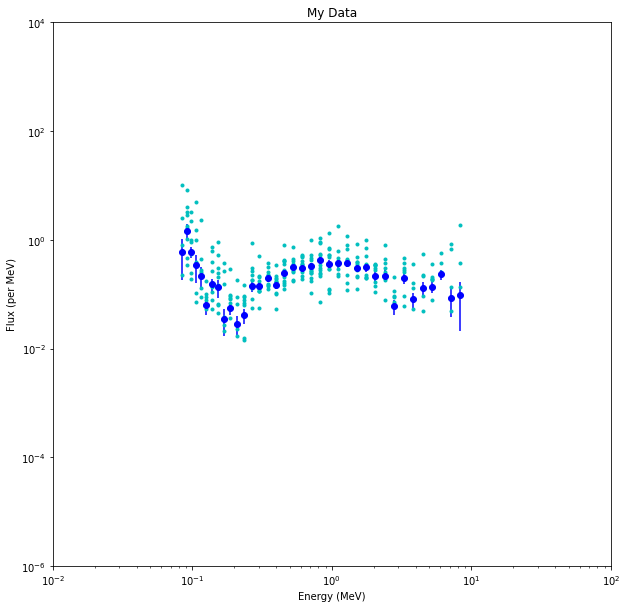

In [4]:
plt.figure(figsize=(10, 10))
plt.xlabel('Energy (MeV)')
plt.xscale('log')
plt.xlim(10e-3, 1e2)
plt.ylabel('Flux (per MeV)')
plt.yscale('log')
plt.ylim(1e-6, 1e4)
plt.title('My Data')

for f in r:
    plt.plot(e.energy[0, 0, :] / 1e3, f, 'c.')  # already scaled by 1e3


r = np.stack(r, axis=0)
u = np.stack(u, axis=0)
    
w = np.array(l)
w = w / np.nanmean(w)
w = np.tile(w[:, None], (1,) + u.shape[1:])

print(r.shape)
print(u.shape)
print(w.shape)

avg = weighted_avg(r, weights=w, axis=0)
err = weighted_avg(u, axis=0, weights=w, unc=True)
plt.errorbar(e.energy[0, 0, :] / 1e3, avg, yerr=err, fmt='bo')
plt.savefig('figures/joyce-apj-fig1.png')


In [5]:
import pprint
pprint.pprint((e.energy[0, 0, :] / 1e3, avg, err))  # to give you an idea of the magnitude of the errror


(array([0.06163965, 0.06521753, 0.06912508, 0.07370056, 0.07820895,
       0.08467033, 0.09113809, 0.09787924, 0.10562747, 0.11460397,
       0.125445  , 0.13754632, 0.15149443, 0.16771485, 0.1868041 ,
       0.20895305, 0.2351812 , 0.26579294, 0.30236328, 0.34594807,
       0.3962242 , 0.45595014, 0.52638924, 0.6089336 , 0.7060035 ,
       0.81965446, 0.95311785, 1.109688  , 1.2932553 , 1.5076807 ,
       1.7592542 , 2.0529258 , 2.3969803 , 2.799171  , 3.2692304 ,
       3.8190017 , 4.4620657 , 5.2136416 , 6.0921164 , 7.1195354 ,
       8.320147  ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan], dtype=float32),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.60882646, 1.46472554, 0.60122644, 0.34687352, 0.2189526 ,
       0.06261999, 0.15196789, 0.13552004, 0.03451033, 0.05668148,
       0.02846359, 0.04123848, 0.14207106, 0.14410698, 0.19624305,
       0.14652194, 0.24608503, 0.31786631, 0.30309849, 0.32856131,


### Comparing My Data to Colin's

In [6]:
import glob
import scipy.io

data_colin = list()
for f in sorted(glob.glob('data/colins-data/*.sav'))[:-1]:  # exclude the totals file for now
    print(f)
    data_colin.append(scipy.io.readsav(f))


data/colins-data/B 0.sav
data/colins-data/B 1.sav
data/colins-data/B 2.sav
data/colins-data/B 3.sav
data/colins-data/B 4.sav
data/colins-data/B 5.sav
data/colins-data/B 6.sav
data/colins-data/B 7.sav
data/colins-data/B 8.sav
data/colins-data/B 9.sav
data/colins-data/B10.sav
data/colins-data/B11.sav
data/colins-data/B12.sav


In [7]:
for i in range(len(data_colin)):
    print('Is close? : {:02d} :'.format(i),
          np.all(np.isclose(r[i], data_colin[i]['lof'],
                            atol=0, rtol=1e-2)[~np.isnan(r[i])]))


Is close? : 00 : True
Is close? : 01 : True
Is close? : 02 : True
Is close? : 03 : True
Is close? : 04 : True
Is close? : 05 : True
Is close? : 06 : True
Is close? : 07 : True
Is close? : 08 : True
Is close? : 09 : True
Is close? : 10 : True
Is close? : 11 : True
Is close? : 12 : True


In [8]:
for i in range(len(data_colin)):
    print('Is close? : {:02d} :'.format(i),
          np.all(np.isclose(u[i], data_colin[i]['dlof'],
                            atol=0, rtol=1e-2)[~np.isnan(r[i])]))


Is close? : 00 : False
Is close? : 01 : True
Is close? : 02 : True
Is close? : 03 : True
Is close? : 04 : True
Is close? : 05 : True
Is close? : 06 : True
Is close? : 07 : True
Is close? : 08 : True
Is close? : 09 : False
Is close? : 10 : True
Is close? : 11 : True
Is close? : 12 : True


In [9]:
for i in range(len(data_colin)):
    print(r[i])
    print(data_colin[i]['lof'])
    print('=' * 20, '^^^^ event {:02d} above ^^^^'.format(i), '=' * 20)
    

[0.         0.         0.         0.         0.         0.8181396
 1.80413727 0.98503028 0.37779843 0.28422626 0.07867419 0.05446229
 0.04598455 0.0207522  0.03719649 0.01737333 0.0159086  0.08003063
 0.11277229 0.15387786 0.19230371 0.23906271 0.29402939 0.29831697
 0.42800347 0.52180699 0.29440507 0.29135851 0.44614023 0.35647714
 0.20830958 0.10957853 0.21770472 0.07191474 0.28150848 0.12955651
 0.21170735 0.18303222 0.57752942 0.13512287 0.                nan
        nan        nan        nan        nan        nan        nan]
[0.         0.         0.         0.         0.         0.81719719
 1.80205909 0.98389562 0.37736324 0.28389886 0.07858356 0.05439955
 0.04593159 0.0207283  0.03715364 0.01735332 0.01589027 0.07993844
 0.11264238 0.15370061 0.1920822  0.23878733 0.2936907  0.29797334
 0.42751045 0.52120592 0.29406594 0.2910229  0.44562632 0.35606651
 0.20806963 0.10945231 0.21745394 0.0718319  0.28118421 0.12940727
 0.21146349 0.18282139 0.57686416 0.13496722 0.         0.
 0.

In [10]:
for i in range(len(data_colin)):
    print(u[i])
    print(data_colin[i]['dlof'])
    print('=' * 20, '^^^^ event {:02d} above ^^^^'.format(i), '=' * 20)


[0.         0.         0.         0.         0.         1.03790251
 0.94433608 0.34210592 0.39089957 0.2442419  0.07111127 0.03699448
 0.03123583 0.02632652 0.01218387 0.02204003 0.00736937 0.04197547
 0.03447894 0.03545624 0.05673884 0.0827565  0.10016161 0.11557884
 0.11314252 0.1396119  0.1274906  0.11584196 0.08538663 0.12738255
 0.091384   0.03671374 0.14220796 0.0415959  0.13410627 0.12920171
 0.08252395 0.07394137 0.31907362 0.06259323 0.                nan
        nan        nan        nan        nan        nan        nan]
[0.         0.         0.         0.         0.         0.81719719
 0.80483571 0.52678465 0.30777653 0.19767212 0.05598978 0.03846744
 0.0324795  0.0207283  0.02627159 0.01735332 0.01589027 0.03584169
 0.03982622 0.0464108  0.05345636 0.07056138 0.08674629 0.09649422
 0.10634368 0.114469   0.10235487 0.10524813 0.13765324 0.11935988
 0.0827051  0.0493039  0.11351472 0.04173959 0.11490279 0.10172755
 0.12064931 0.12332516 0.25622826 0.13496722 0.         0.
 0

/home/asher/.miniconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


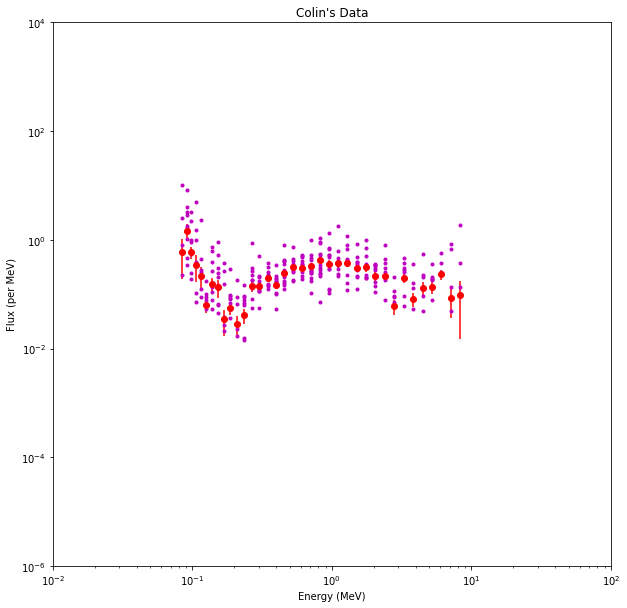

In [11]:
plt.figure(figsize=(10, 10))
plt.xlabel('Energy (MeV)')
plt.xscale('log')
plt.xlim(10e-3, 1e2)
plt.ylabel('Flux (per MeV)')
plt.yscale('log')
plt.ylim(1e-6, 1e4)
plt.title('Colin\'s Data')

for vhere in data_colin:
    plt.plot(e.energy[0, 0, :] / 1e3, vhere['lof'], 'm.')  # already scaled by 1e3
    
    
c_flux = np.stack((vhere['lof'] for vhere in data_colin), axis=0)
avg = weighted_avg(c_flux, weights=w, axis=0)
c_unc = np.stack((vhere['dlof'] for vhere in data_colin), axis=0)
err = weighted_avg(c_unc, axis=0, weights=w, unc=True)

plt.errorbar(e.energy[0, 0, :] / 1e3, avg, yerr=err, fmt='ro')
plt.savefig('figures/joyce-apj-fig1_colins-data.png')


In [12]:
print('{:2s}\t{:^23s}\t\t{:^23s}'.format('id', 'My Data', 'My Data (no nan)'))
for i in range(len(r)):
    rrii = copy.deepcopy(r[i])
    uuii = copy.deepcopy(u[i])
    
    # fill nan with 0
    isnan = np.isnan(rrii)
    rrii[isnan] = 0
    uuii[isnan] = 0
    
    print('{:02d}\t{:8.3e} +/- {:8.3e}\t\t{:8.3e} +/- {:8.3e}'.format(
        i,
        weighted_avg(r[i]), weighted_avg(u[i], unc=True),
        weighted_avg(rrii), weighted_avg(uuii, unc=True)))
    
print('\n\n')

print('{:2s}\t{:^23s}'.format('id', 'Colin\'s Data'))
for i, vhere in enumerate(data_colin):
    print('{:02d}\t{:8.3e} +/- {:8.3e}'.format(
        i,
        weighted_avg(vhere['lof']), weighted_avg(vhere['dlof'], unc=True)))


id	        My Data        		   My Data (no nan)    
00	2.530e-01 +/- 3.944e-02		2.161e-01 +/- 3.369e-02
01	1.411e-01 +/- 4.316e-02		1.205e-01 +/- 3.687e-02
02	3.988e-01 +/- 8.553e-02		3.407e-01 +/- 7.306e-02
03	1.386e-01 +/- 2.743e-02		1.184e-01 +/- 2.343e-02
04	2.626e-01 +/- 5.951e-02		2.243e-01 +/- 5.083e-02
05	1.219e-01 +/- 3.087e-02		1.042e-01 +/- 2.637e-02
06	8.907e-01 +/- 3.492e-01		7.608e-01 +/- 2.983e-01
07	2.184e-01 +/- 6.802e-02		1.865e-01 +/- 5.810e-02
08	2.311e-01 +/- 5.039e-02		1.974e-01 +/- 4.304e-02
09	2.086e-01 +/- 2.438e-02		1.782e-01 +/- 2.082e-02
10	2.289e-01 +/- 7.425e-02		1.955e-01 +/- 6.342e-02
11	1.505e-01 +/- 1.463e-02		1.286e-01 +/- 1.249e-02
12	1.808e-01 +/- 2.078e-02		1.544e-01 +/- 1.775e-02



id	     Colin's Data      
00	2.159e-01 +/- 2.949e-02
01	1.205e-01 +/- 3.687e-02
02	3.407e-01 +/- 7.306e-02
03	1.184e-01 +/- 2.343e-02
04	2.243e-01 +/- 5.083e-02
05	1.042e-01 +/- 2.637e-02
06	7.608e-01 +/- 2.983e-01
07	1.865e-01 +/- 5.823e-02
08	1.974e-01 +/- 4.304e-02

The good news is that we get the same numbers EXCEPT for periods 0 and 9,
which were shown to have (at least) differing flux uncertainties (though
similar data...I do not yet know why the average themselves and not just the
uncertainties match.)


In [13]:
# let's try using energy bin width as the weight for these
weights_e = (e.energy_unc_plus + e.energy_unc_minus) / 1e3
# shouldn't actually matter if I divide by 1000 to get to MeV as the weights
# will all be adjusted...

weights_e[np.isnan(weights_e)] = 0

print('{:2s}\t{:^23s}'.format('id', 'My Data (no nan w/e-bin)'))
for i in range(len(r)):
    rrii = copy.deepcopy(r[i])
    uuii = copy.deepcopy(u[i])
    
    # fill nan with 0
    isnan = np.isnan(rrii)
    rrii[isnan] = 0
    uuii[isnan] = 0
    
    print('{:02d}\t{:8.3e} +/- {:8.3e}'.format(
        i,
        weighted_avg(rrii, weights=weights_e), weighted_avg(uuii, unc=True, weights=weights_e)))

print('\n\n')

print('{:2s}\t{:^23s}'.format('id', 'Colin\'s Data w/e-bin'))
for i, vhere in enumerate(data_colin):
    print('{:02d}\t{:8.3e} +/- {:8.3e}'.format(
        i,
        weighted_avg(vhere['lof'], weights=weights_e), weighted_avg(vhere['dlof'], weights=weights_e, unc=True)))



id	My Data (no nan w/e-bin)
00	2.143e-01 +/- 4.646e-02
01	1.738e-01 +/- 9.841e-02
02	1.630e-01 +/- 6.482e-02
03	1.467e-01 +/- 8.730e-02
04	1.430e-01 +/- 7.380e-02
05	7.063e-02 +/- 3.935e-02
06	4.373e-01 +/- 2.885e-01
07	9.309e-02 +/- 4.601e-02
08	1.234e-01 +/- 6.578e-02
09	1.789e-01 +/- 4.275e-02
10	1.165e-01 +/- 5.832e-02
11	1.706e-01 +/- 3.631e-02
12	1.660e-01 +/- 4.063e-02



id	 Colin's Data w/e-bin  
00	2.141e-01 +/- 4.383e-02
01	1.738e-01 +/- 9.841e-02
02	1.630e-01 +/- 6.482e-02
03	1.467e-01 +/- 8.730e-02
04	1.430e-01 +/- 7.380e-02
05	7.063e-02 +/- 3.935e-02
06	4.373e-01 +/- 2.885e-01
07	9.309e-02 +/- 4.611e-02
08	1.234e-01 +/- 6.578e-02
09	1.787e-01 +/- 6.327e-02
10	1.165e-01 +/- 5.832e-02
11	1.706e-01 +/- 3.631e-02
12	1.660e-01 +/- 4.063e-02


### Figuring out uncertainty problems


In [14]:
eventidx = 0
e = types.SimpleNamespace(**copy.deepcopy(d.eventdata[eventidx]['ChanP']))


In [15]:
unc_nan = np.isnan(e.flux_unc)
unc_nonzero = e.flux_unc != 0
unc_nonzero[unc_nan] = False


In [16]:
# make sure everywhere where we have no uncertainty we have no data
flux_nan = np.isnan(e.flux)
flux_nonzero = e.flux != 0
flux_nonzero[flux_nan] = False

assert(np.all(flux_nonzero == unc_nonzero))


### Notes

In [17]:
# Also, I think this might be an issue with weighted_avg:

weighted_avg(np.stack(u, axis=0), weights=weights, axis=0, unc=True)

# Seems to crash when using weights with uncertainties.



# About above, need to add 1-d case.  See old versions of this in git.

IndexError: boolean index did not match indexed array along dimension 0; dimension is 14907 but corresponding boolean dimension is 13